## Regularization
### Lasso

In statistics and machine learning, lasso (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model. 

The lasso method assumes that the coefficients of the linear model are sparse, meaning that few of them are non-zero.

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [27]:
# Defining the dataset

subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv('house_sales.csv', sep='\t')
print(house[subset].head())


   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


array(['Multiplex', 'Single Family', 'Townhouse'], dtype=object)

In [35]:
    # predictors: A list of column names from the dataset (house) that will be used as features (independent variables) 
    # to predict the target variable.

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

    #outcome: The target variable (dependent variable) to predict, which is AdjSalePrice (the adjusted sale price of the house).
outcome = 'AdjSalePrice'

    # Converts categorical variables in the predictors columns into dummy variables for machine learning.
    # This is necessary because linear regression models cannot directly handle categorical data.
    # "drop_first=True" drops the first category of each categorical variable to avoid multicollinearity
    # And saves this with-dummy-database as X
X = pd.get_dummies(house[predictors], drop_first=True)

    # This line converts the NewConstruction column (originally True/False) into a binary column:
    #    - 1 if the house is newly constructed.
    #    - 0 if it is not.
    # This ensures that the NewConstruction column is in a numeric format suitable for the linear regression model.
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

    # Stores the column names of the feature matrix X for later use
columns = X.columns

    # This line is commented out, but if uncommented, it would standardize the features 
    # (subtract the mean and divide by the standard deviation). 
    # Standardization is often used in linear regression to ensure that all features are on the same scale, 
    # which can improve model performance.
# X = StandardScaler().fit_transform(X * 1.0)

    # Extracts the target variable (AdjSalePrice) from the "house" DataFrame.
y = house[outcome]

# Fit the Linear Regression Model
    # "LinearRegression()": Initializes a linear regression model from the sklearn.linear_model module.    
house_lm = LinearRegression()
    # house_lm.fit(X, y): Fits the linear regression model to the data:
    # print(): Prints the result of the fit method, which is the trained model object.
print(house_lm.fit(X, y))

LinearRegression()


In [57]:
# Fits a Lasso regression model to the data
# Lasso Regression is a type of linear regression that includes L1 regularization.
# L1 regularization adds a penalty proportional to the absolute value of the coefficients to the loss function. 
# alpha=10: This controls the regularization strength. Higher values of alpha result in stronger regularization:
# Large alpha: Drives more coefficients to zero, effectively performing feature selection by excluding less important predictors.
# Small alpha: Makes the model behave more like standard linear regression (less regularization).

house_lasso = Lasso(alpha=10)

    # Fits the Lasso regression model to the predictors (X) and target variable (y).
    # During training:
    #    - The model optimizes coefficients while applying L1 regularization.
    #    - Some coefficients may be shrunk to zero if their contribution to reducing the error doesn't outweigh the penalty.
print(house_lasso.fit(X, y))

    # After fitting, you can access:
    #    - Coefficients: house_lasso.coef_ (some may be exactly zero due to L1 regularization).
    #    - Intercept: house_lasso.intercept_

# Key Properties of Lasso
    # Feature Selection:
    #    - Lasso can reduce some coefficients to zero, effectively removing unimportant features from the model.
    #    - This is especially useful when dealing with high-dimensional data (many predictors).
    # Sparsity:
    #    - Encourages sparse models (models with fewer predictors) by eliminating irrelevant features.
    # Bias-Variance Tradeoff:
    #    - Regularization introduces bias to reduce variance, potentially improving the model's performance on unseen data 
    #      (reduces overfitting).

# Comparison to Linear Regression
#     - While ordinary linear regression (LinearRegression) fits a model by minimizing squared errors, Lasso adds an additional penalty to encourage simplicity.
#     - Lasso performs feature selection automatically, which is beneficial in datasets with many irrelevant or redundant features.


Lasso(alpha=10)


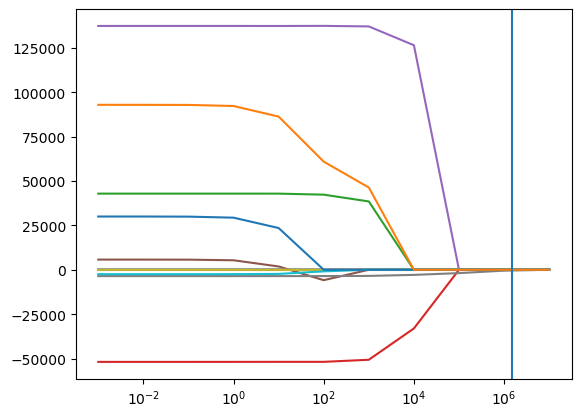

In [63]:
# This code snippet demonstrates how to evaluate the impact of Lasso regularization on the model's coefficients 
# across different values of the regularization parameter alpha, 
# and uses cross-validation to identify the optimal alpha. Here's a detailed explanation:

 # Defining Regression Methods:

# Both Lasso and LassoLars are from sklearn,
# however, they differ in how they solve the optimization problem. Here's a detailed comparison:
# Lasso:
#    - Algorithm: Uses coordinate descent to solve the Lasso optimization problem.
#    - How it works:
#           - Iteratively updates one coefficient at a time while keeping the others fixed.
#           - Uses a cyclic approach to update coefficients, which can be computationally efficient for large datasets.
#    - Strengths:
#           - Works well for large datasets with many features.
#           - Can handle dense and sparse data efficiently.
#           - Often faster than LassoLars for large datasets.
#     - Weaknesses:
#           - May not be as precise as LassoLars in terms of finding the exact regularization path.
#           - Requires tuning the alpha parameter (regularization strength) carefully.

# LassoLars:
#    - Algorithm: Uses the Least Angle Regression (LARS) algorithm with Lasso modification.
#    - How it works:
#           - Computes the full regularization path (i.e., the sequence of solutions for all possible values of the 
#             regularization parameter alpha).
#           - At each step, it adds the feature most correlated with the residual, adjusting coefficients in a way that maintains 
#             the Lasso constraint.
#    - Strengths:
#           - Provides an exact solution to the Lasso problem.
#           - Computes the entire regularization path, which can be useful for understanding how coefficients change with different levels of regularization.
#           - Works well for smaller datasets or when you want to explore the regularization path.
#    - Weaknesses:
#           - Can be slower than Lasso for large datasets or datasets with many features.
#           - Less efficient for very large-scale problems.

# When to Use Which?
# Use Lasso (Coordinate Descent):
#    - When working with large datasets or high-dimensional data.
#    - When computational efficiency is a priority.
#    - When you don't need the exact regularization path.
# Use LassoLars:
#    - When working with smaller datasets.
#    - When you want to explore the full regularization path.
#    - When you need precise control over the Lasso solution.

    
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso      # The Lasso regression model with a manually specified alpha value.
MethodCV = LassoCV  # Lasso regression with built-in cross-validation to automatically find the best alpha.

    # Tracking alpha and Coefficients:
alpha_values = []      # alpha_values: Stores the tested alpha values
results = []           # results: Stores the model's coefficients for each alpha


    # Iterating over alpha values
    # Iterates over a range of alpha values (from very small to very large)
    # For each alpha:
    #     - A Lasso model (Method) is created and fit to the data (X, y).
    #     - The value of alpha is added to the alpha_values list.
    #     - The corresponding model coefficients are added to the results list.

for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)


# Cross-Validation with LassoCV:
    # MethodCV (LassoCV) performs cross-validation (with cv=5 folds) to find the optimal alpha value.
    # After fitting, the optimal alpha can be accessed using "modelCV.alpha_"

# Cross-Validation with LassoCV automates the process of finding the best regularization parameter (alpha) for the Lasso regression.
# Cross-validation (CV) is a technique used to evaluate the performance of a model by splitting the dataset 
# into several parts (called "folds"):
#    - Split the Data: 
#        - The data is divided into k subsets (folds). For example, if cv=5, the dataset is split into 5 parts.
#    - Train and Validate:
#        - The model is trained on k-1 folds and tested on the remaining fold (the validation set).
#        - This process is repeated k times, with each fold used once as the validation set.
#    - Average the Results:
#        - The average performance (mean squared error) across all folds is used to evaluate the model's effectiveness
# The range of the "alpha" values used is determined based on the data (predictors X and target y)

modelCV = MethodCV(cv=5)
modelCV.fit(X, y)


# Plotting Results
    # Data Preparation:
    # Creates a DataFrame where:
    #    - Rows correspond to alpha values (indexed by alpha_values).
    #    - Columns correspond to features in X (columns).
    #    - Each cell contains the coefficient value for a specific feature and alpha.
    # logx=True: Uses a logarithmic scale for the x-axis (important since alpha varies exponentially).

ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)

    # Highlighting the optimal alpha
    # Draws a vertical line at the optimal alpha value identified by cross-validation (LassoCV):
ax.axvline(modelCV.alpha_)
plt.show()

# HOW TO INTERPRET THE PLOT
# This plot visualizes how the coefficients of a Lasso regression model change as the regularization parameter α varies.

'''
_________________________________________________________________________________________________________________________________________________
           
            Key Elements of the Plot

    X-Axis:
        The x-axis shows the α values on a logarithmic scale.
        Smaller α: Minimal regularization (closer to standard linear regression).
        Larger α: Stronger regularization, driving more coefficients to zero.

    Y-Axis:
        The y-axis shows the values of the coefficients for each feature in the model.
        Positive values indicate a positive relationship with the target variable.
        Negative values indicate a negative relationship.

    Lines:
        Each line represents the coefficient of a single feature as α changes.
        The line’s behavior shows how the Lasso model penalizes or removes that feature with increasing regularization.

    Vertical Line (Blue):
        This marks the optimal α value identified using cross-validation (modelCV.alpha_).
        The coefficients at this point represent the chosen Lasso model, balancing simplicity and predictive power.
_________________________________________________________________________________________________________________________________________________

                HOW TO READ IT
                    
1. Left Side (Small α):
    On the far left:
        Regularization is weak.
        Most coefficients are nonzero, and their values are close to those from standard linear regression.
        The model includes almost all features, even those with small or negligible contributions.

2. Middle (Increasing αα):
    As α increases:
        Coefficients start to shrink (move closer to zero).
        Some coefficients reach exactly zero, meaning the Lasso model has excluded those features.
        This is the feature selection property of Lasso regression.

3. Right Side (Large α):
    On the far right (α > 10^4):
        Regularization is very strong.
        Almost all coefficients shrink to zero, except possibly one or two dominant features.
        The model becomes overly simple and likely underfits the data.

4. Vertical Line (Optimal α):
    The vertical line indicates the optimal α value found using cross-validation.
    The coefficients at this α are the ones used in the final Lasso model.
    These coefficients balance model complexity and predictive accuracy.


                What Can You Learn From This Plot?

Feature Importance:
    The features with coefficients that remain nonzero even at higher αα values are likely the most important for predicting 
    the target variable.

Feature Selection:
    Features with coefficients that shrink to zero as α increases are less important and excluded by the Lasso model.

Optimal Model:
    The coefficients at the optimal α represent the best compromise between underfitting (too much regularization) 
    and overfitting (too little regularization).

Model Sparsity:
        The higher the αα, the fewer features the model retains. This plot gives you insight into how sparse your model 
        becomes as α increases.

_________________________________________________________________________________________________________________________________________________

                WHY DOES THE 'OPTIMAL ALPHA" IS PAST THE "UNDERFIT AREA"

Let me explain why the optimal α might appear to be in the "large α" region, 
even though I mentioned that large αα often leads to excessive simplification and underfitting.

The optimal α is determined by minimizing the cross-validated error, 
not by ensuring that the model retains many coefficients or avoids underfitting in a traditional sense. 
Here's why it could happen:

The Data and Problem Context:

    The dataset may inherently have very few important predictors, and most features might be noisy or irrelevant. 
    In such cases, even with large α, the model performs better by keeping only the most essential features and shrinking others to zero.

Trade-off Between Bias and Variance:

    A large α can increase bias (due to underfitting) but reduce variance significantly.
        # REMINDER: 
        - Bias: refers to a systematic error in predictions due to simplifying assumptions made by the model.
        Bias measures how far the model's predicted values are from the true values on average.
        - Variance: describes how much the model's predictions change when it's trained on different datasets
            - A high-variance model is overly complex and fits the training data very closely, 
            capturing not only the true patterns but also the noise in the data.
            It performs well on the training set but poorly on unseen data (overfitting).
            - A low-variance model makes predictions that are more stable across different datasets 
            but might not fully capture the complexity of the true relationship.    
        
        
    If the reduction in variance improves generalization to new data, the model with larger α may have the lowest cross-validation error.

Feature Scaling and Coefficients:

    If the features have vastly different scales or relationships with the target variable, 
    Lasso might heavily penalize less important predictors early (even at moderate α).
    As a result, the model may naturally prefer larger α values, focusing only on dominant predictors.

Cross-Validation Error Minimization:

    Cross-validation evaluates models based on predictive performance rather than interpretability.
    Even if the model with a large α is overly simple, it might generalize better, leading to the smallest cross-validation error.



What This Plot Likely Indicates

    On the Right Side (α>10^4):
        Most coefficients have shrunk to zero, but one or two remain significant. 
        These features likely explain the majority of the variability in the target variable, which makes the model work 
        reasonably well despite its simplicity.

    At the Optimal αα (Vertical Line):
        The optimal α was chosen because it minimizes the cross-validation error, even if it corresponds to a very sparse model.
        This might indicate that the problem is dominated by just one or two features, 
        and additional complexity (lower α) doesn't improve predictions.


_________________________________________________________________________________________________________________________________________________
                
                What You Should Consider

Model Simplicity:
    Lasso inherently prefers sparse models, but if the optimal αα results in excessive regularization 
    (dropping too many features), the model might oversimplify the problem. Verify if the model's performance aligns with domain knowledge.

Revisit Cross-Validation Setup:
    If the data is small or noisy, cross-validation may overestimate the benefit of large α. 
    Adjusting the cv parameter (increasing folds) or using a different evaluation metric might help.

Double-Check Feature Scaling:
    If your features are not properly scaled (standardized), Lasso can unfairly penalize predictors with larger magnitudes, 
    leading to higher α values.
_________________________________________________________________________________________________________________________________________________

                Summary

Even though large α often leads to oversimplified models, the optimal αα might still be large if:

    The dataset only has a few important predictors.
    Simplicity (few features) improves generalization due to noise or collinearity.
    Cross-validation finds that reducing variance outweighs the cost of bias.

You can verify the model's performance at the optimal α by:

    Checking the cross-validated error against other α values.
    Interpreting the retained features—are they meaningful in the context of your problem?





'''



In [ ]:
# That code above:
# - Valuates the behavior of Lasso regularization:
#     - As alpha increases, regularization strengthens, shrinking coefficients toward zero.
#     - For very large alpha, many coefficients become exactly zero, effectively removing those features from the model.

                # REMINDER: Alpha (α) is the hyperparameter that controls the strength of the L1 regularization term. 
                # It determines how much penalty is applied to the absolute values of the coefficients in the regression model.

# - Uses cross-validation (LassoCV) to find the optimal alpha value that balances bias and variance.
# - Produces a plot:
#    - The x-axis shows alpha values on a logarithmic scale.
#    - The y-axis shows feature coefficients.
#    - The vertical line indicates the optimal alpha from cross-validation.

# Why Is This Useful?
#    - Visualizes Regularization Effects: Shows how Lasso prioritizes important features while excluding less relevant ones.
#    - Optimal alpha Selection: Automatically selects the best regularization strength using cross-validation.
#    - Feature Selection Insight: Identifies which features remain significant at different levels of regularization.



In [17]:
# This prints the coefficients from the cross-validation Lasso:
# The coefficients in modelCV.coef_ are already in the original feature scale, so not sure about the values below

pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})


,name,coef
0,SqFtTotLiving,289.048846
1,SqFtLot,0.029471
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.316479
7,YrBuilt,-0.000000
8,YrRenovated,45.727472
9,NewConstruction,-0.000000


In [19]:
## Not sure where these coefficients come from
# Possibly a comparison to previously obtained values

# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308



In [73]:
modelCV.coef_


array([ 2.89048846e+02,  2.94709068e-02,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  3.31647904e+00, -0.00000000e+00,
        4.57274715e+01, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00])

In [69]:
# Having a look at the dataframe created above
pd.DataFrame(results, index=alpha_values, columns=columns)

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction,PropertyType_Single Family,PropertyType_Townhouse
1.000000e-03,198.636425,0.077067,42860.329195,-51865.342462,137266.529676,5723.456076,7.061090,-3574.220949,-2.531076,-2489.097562,29971.696459,92859.397933
1.000000e-02,198.636447,0.077068,42860.322433,-51865.323146,137266.505993,5719.966351,7.061104,-3574.220587,-2.531059,-2488.965935,29965.865927,92853.428550
1.000000e-01,198.636662,0.077070,42860.254806,-51865.129987,137266.269164,5685.069067,7.061242,-3574.216966,-2.530892,-2487.649666,29907.560538,92793.734643
1.000000e+00,198.638817,0.077095,42859.578558,-51863.198391,137263.900858,5336.093642,7.062625,-3574.180754,-2.529213,-2474.486993,29324.502082,92196.791036
1.000000e+01,198.660363,0.077346,42852.815803,-51843.882416,137240.218104,1846.388159,7.076453,-3573.818639,-2.512431,-2342.859985,23494.003823,86227.440790
1.000000e+02,198.640670,0.078548,42280.342722,-51846.271250,137301.363474,-5874.476771,7.439054,-3562.055484,-2.248659,-906.936446,0.000000,60862.750838
1.000000e+03,198.519762,0.069578,38456.324627,-50670.349102,136997.085737,-0.000000,8.976599,-3467.543987,-0.878611,0.000000,-0.000000,46307.623666
1.000000e+04,214.230368,0.021803,0.000000,-33043.686188,126407.809329,-0.000000,11.169222,-2886.014597,8.563500,0.000000,-0.000000,0.000000
1.000000e+05,319.481513,0.003493,0.000000,-0.000000,0.000000,-0.000000,-38.725345,-1889.197066,21.325867,0.000000,-0.000000,0.000000
1.000000e+06,295.792011,0.027101,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-505.890050,39.291140,-0.000000,-0.000000,0.000000
